In [1]:
#모듈 import - tensorflow & keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses, Model
from keras.models import load_model
#callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
#optimizers
from tensorflow.keras.optimizers import SGD,Adam

#모델 성능 평가 
from sklearn.metrics import accuracy_score, confusion_matrix


In [2]:
#모듈 import - data processing
import cv2
from PIL import Image
import matplotlib.image as mpimg
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.preprocessing import LabelEncoder


In [3]:
#모듈 import - others 
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline
import seaborn as sns
from tqdm.notebook import tqdm
import time

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!cd "/content/drive/MyDrive/oct"
!unzip -qq "/content/drive/MyDrive/oct/OCT_small.zip"

replace OCT_small/test/CNV/CNV-6554931-1.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [13]:
#이미지 필터 모듈 import 
from google.colab import files 
src = list(files.upload().values())[0]
open('ImgFilters.py','wb').write(src) 

Saving ImgFilters.py to ImgFilters (1).py


1647

In [14]:
import ImgFilters

In [36]:
total_dir = "/content/OCT_small"
train_dir = "/content/OCT_small/train"
test_dir = "/content/OCT_small/test"

In [37]:
classes = os.listdir(train_dir)
print(classes)

['NORMAL', 'DRUSEN', 'CNV', 'DME']


In [38]:
dataset = {
    "img_path" : [], 
    "class" : [], 
    "split" : []
}

for split in os.listdir(total_dir):
  print(split)
  try : 
    for where in os.listdir(total_dir + "/" + split):
      for image in glob.glob(total_dir+"/"+split+"/"+where+"/*.jpeg"):
        dataset["img_path"].append(image)
        dataset["class"].append(where)
        dataset["split"].append(split)
  except : 
    continue

dataset = pd.DataFrame(dataset)
dataset.head()

validation
train
test


,img_path,class,split
0,/content/OCT_small/validation/NORMAL/NORMAL-40...,NORMAL,validation
1,/content/OCT_small/validation/NORMAL/NORMAL-19...,NORMAL,validation
2,/content/OCT_small/validation/NORMAL/NORMAL-24...,NORMAL,validation
3,/content/OCT_small/validation/NORMAL/NORMAL-41...,NORMAL,validation
4,/content/OCT_small/validation/NORMAL/NORMAL-66...,NORMAL,validation


In [39]:
dataset = dataset.sample(frac=1, random_state = 77)

In [41]:
train_df = dataset[dataset["split"] == "train"]
test_df = dataset[dataset["split"] == "test"]
valid_df = dataset[dataset["split"] == "validation"]

print(test_df.head(10))

                                               img_path   class split
6411  /content/OCT_small/test/NORMAL/NORMAL-4614357-...  NORMAL  test
6963     /content/OCT_small/test/CNV/CNV-4570780-9.jpeg     CNV  test
6940    /content/OCT_small/test/CNV/CNV-154835-108.jpeg     CNV  test
6304  /content/OCT_small/test/NORMAL/NORMAL-4084983-...  NORMAL  test
6349  /content/OCT_small/test/NORMAL/NORMAL-2057504-...  NORMAL  test
6393  /content/OCT_small/test/NORMAL/NORMAL-3939799-...  NORMAL  test
6312  /content/OCT_small/test/NORMAL/NORMAL-7849560-...  NORMAL  test
6888      /content/OCT_small/test/CNV/CNV-931326-1.jpeg     CNV  test
6169  /content/OCT_small/test/NORMAL/NORMAL-8168258-...  NORMAL  test
5962  /content/OCT_small/test/NORMAL/NORMAL-932497-2...  NORMAL  test


Text(0.5, 1.0, 'Validation Dataset')

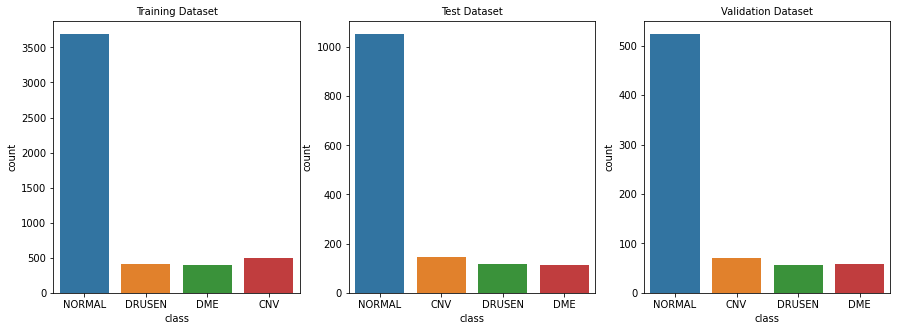

In [43]:
plt.figure(figsize = (15, 5))

plt.subplot(1, 3, 1)
sns.countplot(x=train_df["class"])
plt.title("Training Dataset", size=10)

plt.subplot(1, 3, 2)
sns.countplot(x=test_df["class"])
plt.title("Test Dataset", size=10)


plt.subplot(1, 3, 3)
sns.countplot(x=valid_df["class"])
plt.title("Validation Dataset", size=10)

In [61]:
X_train = train_df["img_path"]
y_train = train_df["class"]

X_test = test_df["img_path"]
y_test = test_df["class"]

X_val = valid_df["img_path"]
y_val = valid_df["class"]


In [71]:
## Check numbers
dfname = ["Train", "Test", "Validation"]
for i, df in enumerate([train_df, test_df, valid_df]):
  print(f"[{dfname[i]} data set]")
  for name in list(df["class"].unique()):
    print(name, len(df[df["class"] == name]))
  print(f"총 {len(df)}개의 파일경로가 있습니다")
  print("-------------------------------")


[Train data set]
NORMAL 3692
DRUSEN 410
DME 396
CNV 497
총 4995개의 파일경로가 있습니다
-------------------------------
[Test data set]
NORMAL 1053
CNV 144
DRUSEN 116
DME 112
총 1425개의 파일경로가 있습니다
-------------------------------
[Validation data set]
NORMAL 524
CNV 71
DRUSEN 56
DME 58
총 709개의 파일경로가 있습니다
-------------------------------


In [57]:
def makearray(img):  
  images = []
  bar_total = tqdm(img)

  for file in bar_total:
    img = ImgFilters.mode_change(file)
    images.append(img)

  images = np.array(images)
  return images


In [58]:
X_train = makearray(X_train)
X_test = makearray(X_test)
X_val = makearray(X_val)

In [ ]:

def makelabel(labels):
  encoder = LabelEncoder()
  encoder.fit(labels)
  labels_encoded = encoder.transform(labels)
  labels_encoded[:3], encoder.classes_
  return labels_encoded

In [ ]:
y_train = makelabel(y_train)
y_test = makelabel(y_test)
y_val = makelabel(y_val)

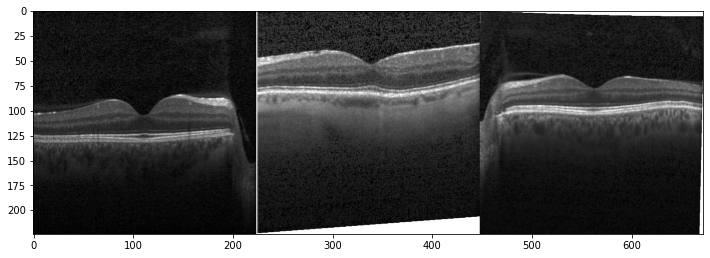

In [59]:
res = np.hstack((X_train[random.choice(range(len(X_train)))], 
                 X_train[random.choice(range(len(X_train)))], 
                 X_train[random.choice(range(len(X_train)))])) 

plt.figure(figsize=(12, 5))
plt.imshow(res)

plt.show()


In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
from tensorflow.keras.applications.mobilenet import MobileNet

IMG_SIZE = 224
model = MobileNet(weights= None, 
                    include_top = True, 
                    input_shape = (IMG_SIZE, IMG_SIZE, 3),
                    classes=4)
model.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=20, verbose=1, mode='min', baseline=None, restore_best_weights=False)
mc = ModelCheckpoint('/content/drive/MyDrive/ir_dog_model.h5', monitor='val_loss', mode='min', save_best_only=True)
rlr_cb = ReduceLROnPlateau(monitor='val_accuracy',  factor=0.3,    patience=10,  mode='max',  verbose=1)     

In [ ]:

optimizers = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(optimizer=optimizers,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:

start_time = time.time()
hist=model.fit(X_train, y_train.reshape(-1, 1),
              epochs=1000, verbose=1, batch_size = 140,
              validation_data = (X_test, y_test.reshape(-1, 1)), shuffle=True,
              callbacks=[early_stopping, rlr_cb])
print('fit time : ', time.time() - start_time )

Epoch 1/1000
36/36 [==============================] - 28s 451ms/step - loss: 0.8508 - accuracy: 0.7219 - val_loss: 1.5599 - val_accuracy: 0.1011
Epoch 2/1000
36/36 [==============================] - 12s 336ms/step - loss: 0.4683 - accuracy: 0.8380 - val_loss: 1.4905 - val_accuracy: 0.1011
Epoch 3/1000
36/36 [==============================] - 12s 337ms/step - loss: 0.3518 - accuracy: 0.8805 - val_loss: 1.1230 - val_accuracy: 0.3972
Epoch 4/1000
36/36 [==============================] - 12s 338ms/step - loss: 0.2620 - accuracy: 0.9145 - val_loss: 1.9105 - val_accuracy: 0.1011
Epoch 5/1000
36/36 [==============================] - 12s 337ms/step - loss: 0.2139 - accuracy: 0.9311 - val_loss: 1.0995 - val_accuracy: 0.6014
Epoch 6/1000
36/36 [==============================] - 12s 337ms/step - loss: 0.2026 - accuracy: 0.9289 - val_loss: 80.9823 - val_accuracy: 0.7389
Epoch 7/1000
36/36 [==============================] - 12s 336ms/step - loss: 0.1631 - accuracy: 0.9479 - val_loss: 2.1135 - val_a

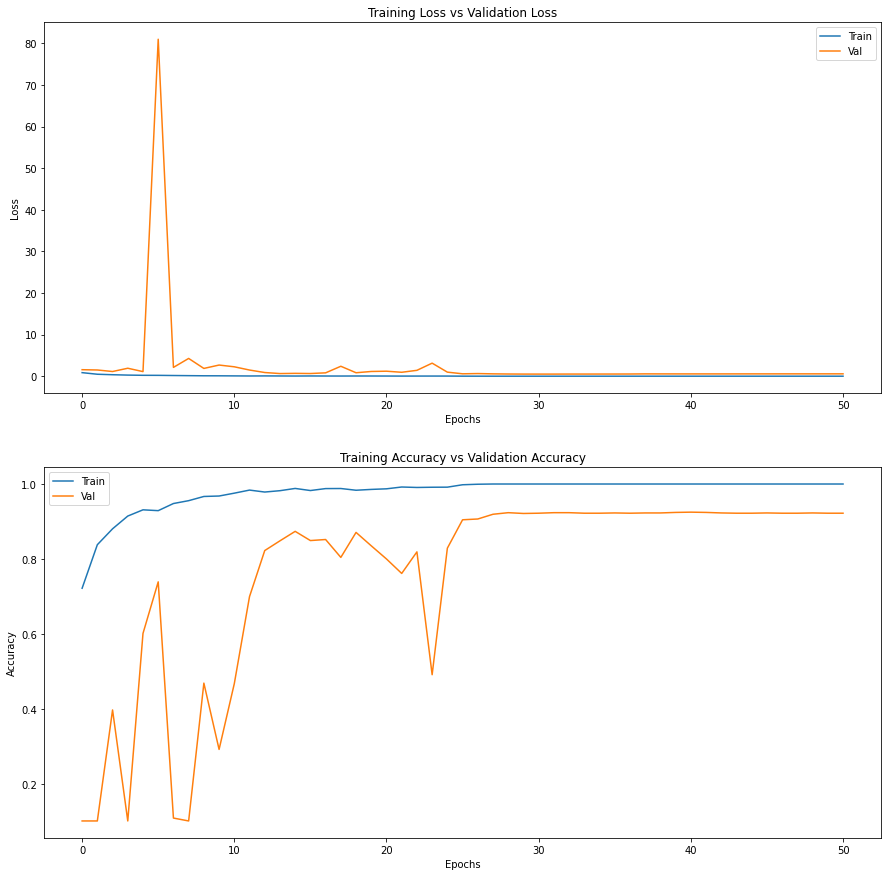

In [ ]:

fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(hist.history['loss'])
axs[0].plot(hist.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(hist.history['accuracy'])
axs[1].plot(hist.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [ ]:
model.evaluate(X_test, y_test)

45/45 [==============================] - 3s 42ms/step - loss: 0.5645 - accuracy: 0.9221


[0.5645115375518799, 0.9221052527427673]

In [ ]:
pred = model.predict(X_val)
pred = np.argmax(pred, axis=1)
accuracy_score(y_val, pred)

accuracy_score(y_val, pred), confusion_matrix(y_val, pred)

(0.9365303244005642, array([[ 67,   1,   3,   0],
        [  2,  49,   0,   7],
        [  3,   0,  32,  21],
        [  0,   2,   6, 516]]))